# Forward Rendering

This notebook demonstrates how to solve the Polarized Radiative Transfer using SHDOM and render an image.

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np

import shdom

'\nImports necessary for this notebook\n'

## Rayleigh Scattering

In [3]:
"""
Rayleigh
"""
tau = 0.2
nx, ny, nz = 3, 3, 3 

rayleigh = shdom.RayleighPolarized(wavelength=0.8)

bounding_box = shdom.BoundingBox(0.0, 0.0, 0.0, 1.0, 1.0, 1.0)
grid = shdom.Grid(bounding_box=bounding_box, nx=nx, ny=ny, nz=nz)

alb_data = np.full(shape=(nx, ny, nz), fill_value=1.0, dtype=np.float32)
ext_data = np.full(shape=(nx, ny, nz), fill_value=tau/nz, dtype=np.float32)
phase_data = np.tile(rayleigh.phase[:, :, np.newaxis, np.newaxis, np.newaxis], (1, 1, grid.nx, grid.ny, grid.nz))

extinction_a = shdom.GridData(grid, ext_data)
albedo_a = shdom.GridData(grid, alb_data)
phase_a = shdom.GridPhaseMatrix(grid, phase_data)

air = shdom.Medium()
air.set_optical_properties(extinction_a, albedo_a, phase_a)

'\nRayleigh\n'

In [4]:
numerical_params = shdom.NumericalParameters(deltam=False)
source = shdom.SolarSource(azimuth=-45, zenith=165)
scene_params = shdom.SceneParameters(
    wavelength=0.8,
    source=source,
    boundary_conditions={'y': shdom.BoundaryCondition.periodic, 
                         'x': shdom.BoundaryCondition.periodic},
    surface=shdom.LambertianSurface(albedo=0.0)
) 
rte_solver = shdom.RteSolverPolarized(num_stokes=3, 
                                      scene_params=scene_params, 
                                      numerical_params=numerical_params)
rte_solver.init_medium(air)

print(rte_solver.info)

Scene Parameters: 
   Wavelength: [0.8 micron]
   Surface: [Lambertian, albedo: 0.0]
   Source: [Solar, flux: 1.0, azimuth: -45deg, zenith: 165deg]
   Boundary Conditions: [x:periodic, y:periodic]

Numerical Parameters: 
   acceleration_flag: True
   adapt_grid_factor: 5
   deltam: False
   cell_to_point_ratio: 1.5
   num_mu_bins: 8
   high_order_radiance: True
   max_total_mb: 10000.0
   solution_accuracy: 0.0001
   spherical_harmonics_accuracy: 0.01
   split_accuracy: 0.1
   num_phi_bins: 16
   num_sh_term_factor: 5



In [5]:
"""
Solve the Polarized Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure (shdomsub1.f).
"""
rte_solver.solve(maxiter=100)

'\nSolve the Polarized Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure (shdomsub1.f).\n'

In [6]:
"""
Measure the reflected stokes vector along the solar principle plane.
Plot the reflectance I and Q components (Fig. 3 of  https://arxiv.org/pdf/1901.01813.pdf)
"""
sensor = shdom.ReflectancePolarizedSensor(wavelength=0.8,
                                          x=0.5, 
                                          y=0.5, 
                                          z=1.0, 
                                          resolution=3)
dolp = sensor.render(rte_solver)[1]

'\nMeasure the reflected stokes vector along the solar principle plane.\nPlot the reflectance I and Q components (Fig. 3 of  https://arxiv.org/pdf/1901.01813.pdf)\n'

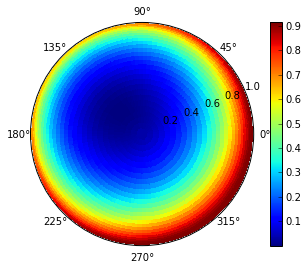

In [7]:
azimuth = sensor.phi.reshape(sensor.resolution, order='F')
radius = np.sqrt(1-sensor.mu**2).reshape(sensor.resolution, order='F')
dolp_image = dolp.reshape(sensor.resolution, order='F')

%matplotlib inline
plt.subplot(projection='polar')
plt.pcolormesh(azimuth, radius, dolp_image)
plt.colorbar()

## Mie Scattering

In [2]:
"""
Generate a uniform infinite layer cloud with properties matching case A5 - Liquid Water Cloud from
IPRT comparison project: https://arxiv.org/pdf/1901.01813.pdf
"""

Generator = shdom.Generate.HomogeneousPolarized

class Args:
    nx=10
    ny=10
    nz=10
    extinction=5.0
    reff=10.0
    albedo=1.0
    domain_size=1.0
    mie_table_path='../mie_tables/Water_800nm_pol.scat'
    
args = Args()
generator = Generator(args)
atmosphere = shdom.Medium()
atmosphere.set_optical_properties(generator.extinction, generator.albedo, generator.phase)

numerical_params = shdom.NumericalParameters()
source = shdom.SolarSource(azimuth=180, zenith=130)
scene_params = shdom.SceneParameters(
    wavelength=0.8,
    source=source,
    boundary_conditions={'y': shdom.BoundaryCondition.periodic, 
                         'x': shdom.BoundaryCondition.periodic},
    surface=shdom.LambertianSurface(albedo=0.0)
) 
rte_solver = shdom.RteSolverPolarized(num_stokes=4, 
                                      scene_params=scene_params, 
                                      numerical_params=numerical_params)
rte_solver.init_medium(atmosphere)

print(rte_solver.info)

'\nGenerate a uniform infinite layer cloud with properties matching case A5 - Liquid Water Cloud from\nIPRT comparison project: https://arxiv.org/pdf/1901.01813.pdf\n'

Reading mie table from file: ../mie_tables/Water_800nm_pol.scat
Done.
Scene Parameters: 
   Wavelength: [0.8 micron]
   Surface: [Lambertian, albedo: 0.0]
   Source: [Solar, flux: 1.0, azimuth: 180deg, zenith: 130deg]
   Boundary Conditions: [x:periodic, y:periodic]

Numerical Parameters: 
   acceleration_flag: True
   adapt_grid_factor: 5
   deltam: True
   cell_to_point_ratio: 1.5
   num_mu_bins: 8
   high_order_radiance: True
   max_total_mb: 10000.0
   solution_accuracy: 0.0001
   spherical_harmonics_accuracy: 0.01
   split_accuracy: 0.1
   num_phi_bins: 16
   num_sh_term_factor: 5



In [3]:
"""
Solve the Polarized Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure (shdomsub1.f).
"""
rte_solver.solve(maxiter=100)

'\nSolve the Polarized Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure (shdomsub1.f).\n'

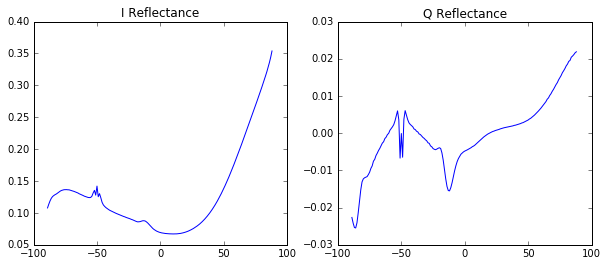

In [5]:
"""
Measure the reflected stokes vector along the solar principle plane.
Plot the reflectance I and Q components (Fig. 3 of  https://arxiv.org/pdf/1901.01813.pdf)
"""
sensor = shdom.PrincipalPlaneSensorPolarized(wavelength=0.8, source=source, x=0.5, y=0.5, z=1.0)
stokes = sensor.render(rte_solver)[0]

%matplotlib inline
f, axes = plt.subplots(1, 2, figsize=(10, 4));
axes[0].plot(sensor.angles, stokes[0,:]);
axes[0].set_title('I Reflectance');
axes[1].plot(sensor.angles, stokes[1,:]);
axes[1].set_title('Q Reflectance');

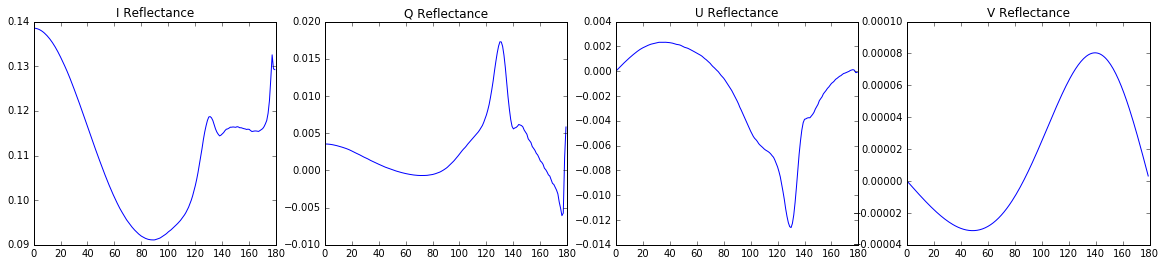

In [9]:
"""
Measure the reflected stokes vector along the solar almucantar plane.
Plot the reflectance I, Q, U, V components (Fig. 4 of  https://arxiv.org/pdf/1901.01813.pdf)

Note: 
The azimuth of the plots has a 180deg difference
"""
sensor = shdom.AlmucantarSensorPolarized(wavelength=0.8, source=source, x=0.5, y=0.5, z=1.0, resolution=1.0)
stokes = sensor.render(rte_solver)[0]
azimuth = sensor.azimuth-180

%matplotlib inline
f, axes = plt.subplots(1, 4, figsize=(20, 4));
axes[0].plot(azimuth, stokes[0,:])
axes[0].set_title('I Reflectance');
axes[1].plot(azimuth, stokes[1,:])
axes[1].set_title('Q Reflectance');
axes[2].plot(azimuth, stokes[2,:])
axes[2].set_title('U Reflectance');
axes[3].plot(azimuth, stokes[3,:])
axes[3].set_title('V Reflectance');

## Stratocumulus Cloud

In [2]:
"""
TODO
"""

# Mie scattering for water droplets
mie = shdom.MiePolarized()
mie.read_table(file_path='../mie_tables/Water_800nm_pol.scat')


# Generate a Microphysical medium
csv_path = '../synthetic_cloud_fields/shdom/les_stcu.txt'
microphysics = shdom.MicrophysicalMedium()
microphysics.load_from_csv(csv_path)

# Rayleigh scattering for air molecules
temperatures = np.array([280.0, 283.64, 283.41, 283.17, 282.94, 282.72, 282.50, 282.29, 282.11, 
                         281.95, 281.82, 281.69, 281.58, 281.50, 281.71, 283.87, 286.190])
temp_grid = shdom.Grid(z=microphysics.grid.z)
temperature_profile = shdom.GridData(temp_grid, temperatures)
rayleigh = shdom.RayleighPolarized(wavelength=0.8)
rayleigh.init_temperature_profile(temperature_profile)

cloud = shdom.Medium()
air = shdom.AmbientMedium()
    
extinction_c, albedo_c, phase_c = mie.interpolate_scattering_field(microphysics.lwc, microphysics.reff, phase_type='Tabulated')
extinction_a, albedo_a, phase_a = rayleigh.get_scattering_field(temp_grid, phase_type='Tabulated')

cloud.set_optical_properties(extinction_c, albedo_c, phase_c)
air.set_optical_properties(extinction_a, albedo_a, phase_a)
    
atmosphere = cloud + air

'\nTODO\n'

Reading mie table from file: ../mie_tables/Water_800nm_pol.scat
Done.


In [3]:
numerical_params = shdom.NumericalParameters()
scene_params = shdom.SceneParameters(
    wavelength=0.8,
    source=shdom.SolarSource(azimuth=65, zenith=135),
    boundary_conditions={'y': shdom.BoundaryCondition.periodic, 
                         'x': shdom.BoundaryCondition.periodic},
)

rte_solver = shdom.RteSolverPolarized(3, scene_params, numerical_params)
rte_solver.init_medium(atmosphere)
print(rte_solver.info)

Scene Parameters: 
   Wavelength: [0.8 micron]
   Surface: [Lambertian, albedo: 0.05]
   Source: [Solar, flux: 1.0, azimuth: 65deg, zenith: 135deg]
   Boundary Conditions: [x:periodic, y:periodic]

Numerical Parameters: 
   acceleration_flag: True
   adapt_grid_factor: 5
   deltam: True
   cell_to_point_ratio: 1.5
   num_mu_bins: 8
   high_order_radiance: True
   max_total_mb: 10000.0
   solution_accuracy: 0.0001
   spherical_harmonics_accuracy: 0.01
   split_accuracy: 0.1
   num_phi_bins: 16
   num_sh_term_factor: 5



In [4]:
rte_solver.solve(maxiter=100)

In [5]:
norm = lambda x: x / np.linalg.norm(x, axis=0)
import itertools

class ProjectiveMonochromeSensor(shdom.SensorPolarized):
    """
    A ProjectiveMonochromeSensor has a projective tansformation that relates 3D coordinate to pixels.
    When rendering, this sensor will produce 2D images.
    """
    def __init__(self, wavelength):
        super(ProjectiveMonochromeSensor, self).__init__()
        self._type = 'ProjectiveMonochromeSensor'
        self._resolution = None
        self._wavelength = wavelength
    
    def project(self, projection_matrix, point_array):
        """
        Project 3D coordinates according to the sensor projection matrix
        
        Parameters
        ----------
        projection matrix: np.array(shape=(3,4), dtype=float)
            The sensor projection matrix K.
        point_array: np.array(shape=(3, num_points), dtype=float)
            An array of num_points 3D points (x,y,z) [km]
        """
        homogenic_point_array = np.pad(point_array,((0,1),(0,0)),'constant', constant_values=1)
        return np.dot(projection_matrix, homogenic_point_array) 
        
    def render(self, rte_solver):
        """
        The render method integrates a pre-computed in-scatter field (source function) J over the sensor gemoetry.
        The source code for this function is in shdomsub4.f. 
        It is a modified version of the original SHDOM visualize_radiance subroutine in shdomsub2.f.
        
        Parameters
        ----------
        rte_solver: shdom.RteSolver object
            The RteSolver with the precomputed radiative transfer solution (RteSolver.solve method).
        
        Returns
        -------
        radiance: np.array(shape=(sensor.resolution), dtype=np.float)
            The rendered radiances.
        """
        visout = super(ProjectiveMonochromeSensor, self).render(rte_solver)[1]
        return visout.reshape(self.resolution, order='F')
    
    @property
    def resolution(self):
        return self._resolution

class PerspectiveMonochromeSensor(ProjectiveMonochromeSensor):
    """
    A Monochromatic Sensor with a Perspective trasnormation 
    (a pinhole camera).
    
    wavelength: float
        Monochromatic wavelength [Micron]
    fov: float
        Field of view [deg]
    nx: int
        Number of pixels in camera x axis
    ny: int
        Number of pixels in camera y axis
    x: float
        Location in global x coordinates [km] (North)
    y: float
        Location in global y coordinates [km] (East)
    z: float
        Location in global z coordinates [km] (Up)
    """
    
    def __init__(self, wavelength, fov, nx, ny, x, y, z):
        super(PerspectiveMonochromeSensor, self).__init__(wavelength)
        self.type = 'PerspectiveMonochromeSensor'

        self._resolution = [nx, ny]
        self._npix = nx*ny
        self._position = np.array([x, y, z], dtype=np.float32)
        self._fov = fov
        self._focal = 1.0 / np.tan(np.deg2rad(fov) / 2.0)
        self._k = np.array([[self._focal, 0, 0],
                            [0, self._focal, 0],
                            [0, 0, 1]], dtype=np.float32)
        self._inv_k = np.linalg.inv(self._k)
        self._rotation_matrix = np.eye(3)
        x_c, y_c, z_c = np.meshgrid(np.linspace(-1, 1, nx), np.linspace(-1, 1, ny), 1.0)        
        self._homogeneous_coordinates = np.stack([x_c.ravel(), y_c.ravel(), z_c.ravel()])
        self.update_global_coordinates()
        
        
    def update_global_coordinates(self):
        """
        This is an internal method which is called upon when a rotation matrix is computed to update the global camera coordinates.
        """
        x_c, y_c, z_c = norm(np.matmul(
            self._rotation_matrix, np.matmul(self._inv_k, self._homogeneous_coordinates)))

        self._mu = -z_c.astype(np.float64)
        self._phi = (np.arctan2(y_c, x_c) + np.pi).astype(np.float64)
        self._x = np.full(self.npix, self.position[0], dtype=np.float32)
        self._y = np.full(self.npix, self.position[1], dtype=np.float32)
        self._z = np.full(self.npix, self.position[2], dtype=np.float32)
    
    
    def look_at_transform(self, point, up):
        """
        A look at transform is defined with a point and an up vector.
        
        Parameters
        ----------
        point: np.array(shape=(3,), dtype=float)
            A point in 3D space (x,y,z) coordinates in [km]
        up: np.array(shape=(3,), dtype=float)
            The up vector determines the roll of the camera.
        """
        up = np.array(up)
        direction = np.array(point) - self.position
        zaxis = norm(direction)
        xaxis = norm(np.cross(up, zaxis))
        yaxis = np.cross(zaxis, xaxis)
        self._rotation_matrix = np.stack((xaxis, yaxis, zaxis), axis=1)
        self.update_global_coordinates()
        
        
    def rotate_transform(self, axis, angle):
        """
        Rotate the camera with respect to one of it's (local) axis
        
        Parameters
        ----------
        axis: 'x', 'y' or 'z'
            The rotation axis
        angle: float
            The angle of rotation [deg]
            
        Notes
        -----
        The axis are in the camera coordinates
        """
        
        assert axis in ['x', 'y', 'z'], 'axis parameter can only recieve "x", "y" or "z"'
        angle = np.deg2rad(angle)
        if axis == 'x':
            rot = np.array([[1, 0, 0],
                            [0, np.cos(angle), -np.sin(angle)],
                            [0, np.sin(angle), np.cos(angle)]], dtype=np.float32)
        elif axis == 'y':
            rot = np.array([[np.cos(angle), 0, np.sin(angle)],
                            [0, 1, 0],
                            [-np.sin(angle), 0, np.cos(angle)]], dtype=np.float32)
        elif axis == 'z':
            rot = np.array([[np.cos(angle), -np.sin(angle), 0],
                            [np.sin(angle), np.cos(angle), 0],
                            [0, 0, 1]], dtype=np.float32)        
        
        self._rotation_matrix = np.matmul(self._rotation_matrix, rot)
        self.update_global_coordinates()
        
        
    def plot(self, ax, xlim, ylim, zlim, length=0.1):
        mu = -self.mu.reshape(self.resolution)[[0, -1, 0, -1],[0, 0, -1, -1]]
        phi = np.pi + self.phi.reshape(self.resolution)[[0, -1, 0, -1],[0, 0, -1, -1]]
        u = np.sqrt(1 - mu**2) * np.cos(phi)
        v = np.sqrt(1 - mu**2) * np.sin(phi)
        w = mu
        x = np.full(4, self.position[0], dtype=np.float32)
        y = np.full(4, self.position[1], dtype=np.float32)
        z = np.full(4, self.position[2], dtype=np.float32)
        ax.set_aspect('equal')
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.set_zlim(*zlim)
        ax.quiver(x, y, z, u, v, w, length=length, pivot='tail')
        
        
    @property
    def position(self):
        return self._position
    
class OrthographicMonochromeSensor(ProjectiveMonochromeSensor):
    """
    A parallel ray projection Sensor measures radiance along rays. 
    
    Parameters
    ----------
    wavelength: float
        Monochromatic wavelength [Micron]
    bounding_box: shdom.BoundingBox object
        The bounding box is used to compute a projection that will make the entire bounding box visible.
    x_resolution: float
        Pixel resolution [km] in x axis (North)
    y_resolution: float
        Pixel resolution [km] in y axis (East)
    azimuth: float
        Azimuth angle [deg] of the radiance measurements (direciton of the photons)
    zenith: float
        Zenith angle [deg] of the radiance measurements (direciton of the photons)
    altitude: float or 'TOA' (default)
       1. 'TOA': measurements of exiting radiace at the top of the atmosphere.
       2. float: Altitude of the radiance measurements.    
    """
    
    def __init__(self, wavelength, bounding_box, x_resolution, y_resolution, azimuth, zenith, altitude='TOA'):
        super(OrthographicMonochromeSensor, self).__init__(wavelength)
        self.type = 'OrthographicMonochromeSensor'
        
        self._x_resolution = x_resolution
        self._y_resolution = y_resolution
        
        mu = np.cos(np.deg2rad(zenith))
        phi = np.deg2rad(azimuth)
        if altitude == 'TOA':
            self._altitude = bounding_box.zmax
        else:
            assert (type(altitude) == float or type(altitude) == int), 'altitude of incorrect type'
            self._altitude = altitude        
            
        # Project the bounding box onto the image plane
        alpha = np.sqrt(1 - mu**2) * np.cos(phi) / mu
        beta  = np.sqrt(1 - mu**2) * np.sin(phi) / mu
        projection_matrix = np.array([
            [1, 0, -alpha, alpha* self.altitude],
            [0, 1,  -beta, beta * self.altitude],
            [0, 0,      0,        self.altitude]
        ])
        
        self.projection_matrix = projection_matrix
        bounding_box_8point_array = np.array(list(itertools.product([bounding_box.xmin, bounding_box.xmax], 
                                                                    [bounding_box.ymin, bounding_box.ymax],
                                                                    [bounding_box.zmin, bounding_box.zmax]))).T
        projected_bounding_box = self.project(projection_matrix, bounding_box_8point_array)
            
        # Use projected bounding box to define image sampling
        x_s, y_s = projected_bounding_box[:2,:].min(axis=1)
        x_e, y_e = projected_bounding_box[:2,:].max(axis=1)
        x = np.arange(x_s, x_e+1e-6, self.x_resolution)
        y = np.arange(y_s, y_e+1e-6, self.y_resolution)
        z = self.altitude
        self._x, self._y, self._z, self._mu, self._phi = np.meshgrid(x, y, z, mu, phi)
        self._x = self._x.ravel().astype(np.float32)
        self._y = self._y.ravel().astype(np.float32)
        self._z = self._z.ravel().astype(np.float32)
        self._mu = self._mu.ravel().astype(np.float64)
        self._phi = self._phi.ravel().astype(np.float64)
        self._npix = self.x.size
        self._resolution = [x.size, y.size]

    @property 
    def altitude(self):
        return self._altitude
    
    @property 
    def x_resolution(self):
        return self._x_resolution
     
    @property 
    def y_resolution(self):
        return self._y_resolution

In [6]:
sensor = OrthographicMonochromeSensor(
    wavelength=scene_params.wavelength,
    bounding_box=cloud.bounding_box, 
    x_resolution=0.02, 
    y_resolution=0.02, 
    azimuth=0.0, 
    zenith=0.0,
    altitude='TOA'
)

dolp = sensor.render(rte_solver)

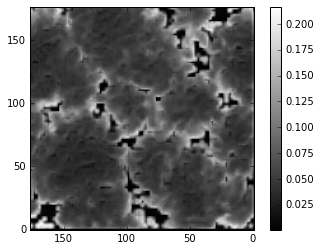

In [7]:
%matplotlib inline
plt.imshow(dolp.T)
plt.gca().invert_yaxis() 
plt.gca().invert_xaxis() 
plt.gray()
plt.colorbar()

In [14]:
sensor = PerspectiveMonochromeSensor(wavelength=0.8, fov=45, nx=600, ny=600, x=1.5, y=1.5, z=5.0)
sensor.look_at_transform([1.0, 1.0, 0.0], [0.0, 1.0, 1.0])

dolp = sensor.render(rte_solver)

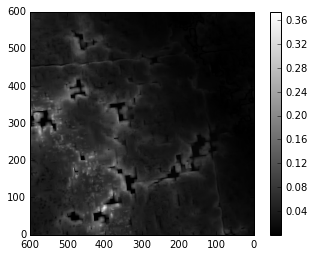

In [15]:
%matplotlib inline
plt.imshow(dolp)
plt.gca().invert_yaxis() 
plt.gca().invert_xaxis()
plt.gray()
plt.colorbar()